In [317]:
import pandas as pd
import numpy as np
import spacy
import re
import string
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


from bs4 import BeautifulSoup


import spacy

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [253]:
nlp = spacy.load("en_core_web_lg")

In [280]:
df= pd.read_csv('api_data.csv',index_col=0)
print(df.shape)
df.head()

(4417, 6)


,title,score,id,subreddit,num_comments,body
0,Do we know of any diseases dinosaurs could hav...,2,hcxfcd,askscience,0,I get that paleontology doesn't get much in th...
1,Do all animals have an internal compass? How d...,4,hcqbk1,askscience,3,Always wondered how birds and fish never got l...
2,Does a plane have to slow down after dropping ...,1,hcplk2,askscience,4,If a plane drops a heavy payload while in flig...
3,What causes the rotational speeds of planets t...,3,hcpqvw,askscience,7,I noticed that the rotational speeds of planet...
4,We have active cancer cells in labs that have ...,3,hcpzjo,askscience,12,NaN


In [281]:
#Shuffling the data
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,title,score,id,subreddit,num_comments,body
0,Psychological Research and COVID-19: Are a Few...,3,gizfsj,psychology,0,NaN
1,"Other than the US, where do you think the best...",19,fzz190,datascience,38,NaN
2,ELI5: What's the difference between sapience a...,2,hccfeb,explainlikeimfive,3,NaN
3,Why does time seem to move so slowly when we'r...,32,fquzap,psychology,2,NaN
4,Eli5 What makes blue fire hotter than normal r...,2,hb1yn1,explainlikeimfive,5,NaN


In [282]:
#how many unique titles do we have?
df['title'].nunique() 

4355

There are 62 duplicate titles in this dataset

In [283]:
#how many unique subreddits do we have?
df['subreddit'].nunique() 

5

In [284]:
df[['title', 'subreddit']].duplicated().sum()

52

In [285]:
#dropping those uplicate
df.drop_duplicates(subset=['title', 'subreddit'], keep='last', inplace=True)
df['subreddit'].value_counts()

explainlikeimfive    991
EverythingScience    961
psychology           862
datascience          821
askscience           730
Name: subreddit, dtype: int64

In [286]:
# Check for nulls
df.isnull().sum()

title              0
score              0
id                 0
subreddit          0
num_comments       0
body            2646
dtype: int64

In [287]:
# Examine rows with null texts
df[df.body.isnull()]

,title,score,id,subreddit,num_comments,body
0,Psychological Research and COVID-19: Are a Few...,3,gizfsj,psychology,0,NaN
1,"Other than the US, where do you think the best...",19,fzz190,datascience,38,NaN
2,ELI5: What's the difference between sapience a...,2,hccfeb,explainlikeimfive,3,NaN
3,Why does time seem to move so slowly when we'r...,32,fquzap,psychology,2,NaN
4,Eli5 What makes blue fire hotter than normal r...,2,hb1yn1,explainlikeimfive,5,NaN
...,...,...,...,...,...,...
4406,"How Fish Got Onto Land, and Stayed There",0,hayhp6,EverythingScience,0,NaN
4408,ELI5 If modern video games are developed on PC...,2,hb2tet,explainlikeimfive,4,NaN
4410,ELI5: Why ants are attracted to electrical dev...,2,harrdc,explainlikeimfive,6,NaN
4413,"ELI5: If energy turbines (hydroelectric, wind,...",4,hcs25c,explainlikeimfive,5,NaN


In [288]:
# Replace null texts with empty string
df.body.fillna(value='', inplace=True)

In [289]:
# Put titles and texts into a single column.
df['text'] = df['title'] + ' ' + df['body']

In [290]:
df = df[['text', 'score', 'id', 'subreddit','num_comments']]
print(df.shape)
df.head()

(4365, 5)


,text,score,id,subreddit,num_comments
0,Psychological Research and COVID-19: Are a Few...,3,gizfsj,psychology,0
1,"Other than the US, where do you think the best...",19,fzz190,datascience,38
2,ELI5: What's the difference between sapience a...,2,hccfeb,explainlikeimfive,3
3,Why does time seem to move so slowly when we'r...,32,fquzap,psychology,2
4,Eli5 What makes blue fire hotter than normal r...,2,hb1yn1,explainlikeimfive,5


### Explore Text

In [291]:
df['text'].value_counts().to_frame()

,text
"Your math ability can depend on the language that you speak, due to differences in the mental representation of number",2
Young people with early psychosis may not require antipsychotic medications to recover,2
"Has Twitter just had its saddest fortnight ever? - ""A tool that quantifies global happiness on social media recorded an unprecedented dip in mood starting in May.""",2
"The moral machine - By 'reading' books and news articles, machines can be taught 'right' from 'wrong' and adopt a human-like moral compass to analyze the development of moral values in societies over time",2
Awessssommmeee! Stretchable Words Make Language More Emotive - The latest research (2020) on stretched words by Tyler Gray and colleagues at the University of Vermont is the most comprehensive study to date that uses big data to analyze how people use stretched words on a social media platform.,2
...,...
Some ways to cope with anxiety around coronavirus,1
"Treating coronavirus takes serious toll on health care workers mental health. The study measured 1,257 responses to surveys and found that approximately 50% of participants experienced depressive symptoms; 45% experienced anxiety; 34% experienced insomnia; and 72% experienced distress.",1
The COVID-19 pandemic is affecting the mental well-being of people in communities under lockdown.,1
"ELI5: Why do some noises sound good to us, and others dont? If we listen to music we like the ''noise'', it sounds good to us. However when someone scratches a fork across a plate it doesnt. Why?",1


In [292]:
import re
import nltk
import pandas as pd
from nltk.stem import PorterStemmer
 
def my_preprocessor(text):
    
    text=text.lower() 
    text=re.sub("\\W"," ",text) # remove special chars
    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)
    text=re.sub("\\s+(in|the|all|for|and|on)\\s+","",text) # normalize certain words
    # remove special characters and digits
    text=re.sub("(\\d|\\W|\\n)+"," ",text)
    
    return text

In [293]:
# STOP_WORDS = nlp.Defaults.stop_words.union([''])
# def my_tokenizer(document):
    
#     doc = nlp(document)
    
#     return  [token.lemma_ for token in doc if (token not in STOP_WORDS) and (token.is_punct != True) and (token.pos_ != '-PRON-' )]
    

In [294]:
df['clean_text'] = df['text'].apply(my_preprocessor)
df.head()

,text,score,id,subreddit,num_comments,clean_text
0,Psychological Research and COVID-19: Are a Few...,3,gizfsj,psychology,0,psychological researchcovid are a few notes ne...
1,"Other than the US, where do you think the best...",19,fzz190,datascience,38,other thanus where do you thinkbest place to b...
2,ELI5: What's the difference between sapience a...,2,hccfeb,explainlikeimfive,3,eli what sdifference between sapiencesentience
3,Why does time seem to move so slowly when we'r...,32,fquzap,psychology,2,why does time seem to move so slowly when we r...
4,Eli5 What makes blue fire hotter than normal r...,2,hb1yn1,explainlikeimfive,5,eli what makes blue fire hotter than normal re...


In [298]:
# transform target variable
encoder = LabelEncoder()
encoder.fit(df['subreddit'])
y = encoder.transform(df['subreddit'])
list(encoder.classes_)

['EverythingScience',
 'askscience',
 'datascience',
 'explainlikeimfive',
 'psychology']

### Preprocessing and Modeling

In [296]:
# Train/Test split before creating features
X_train, X_test, y_train, y_test= train_test_split(df['clean_text'], y,test_size = 0.2, random_state= 42, stratify= df['subreddit'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3492,), (873,), (3492,), (873,))

In [270]:
# # Split data into X and y
# features = ['clean_text']
# X_train= train[features]
# X_test = test[features]
# X_train.shape, X_test.shape

((3492, 1), (873, 1))

In [311]:
#create pipline
vect = TfidfVectorizer(stop_words='english', 
                       ngram_range=(1,2),
                       min_df=0.02, 
                       max_df=0.75,
                       max_features=2000)

In [313]:
# Get sparse dtm
dtm = vect.fit_transform(train['clean_text'])

# Convert to dataframe
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,able,actually,better,brain,change,com,come,coronavirus,covid,data,data science,data scientist,did,different,does,doesn,doing,don,eli,eli does,feel,getting,going,good,having,help,https,https www,job,just,know,learning,like,long,look,looking,lot,machine,make,makes,mean,model,need,new,people,possible,post,project,question,questions,really,research,say,science,scientist,scientists,start,study,sure,thanks,things,think,time,trying,understand,use,used,using,ve,want,way,wondering,work,working,www,years
0,0.0,0.0,0.0,0.902354,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.158109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.267606,0.0,0.0,0.298572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747298,0.0,0.664489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.332999,0.272435,0.0,0.0,0.0,0.0,0.0,0.448183,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.695927,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Word')

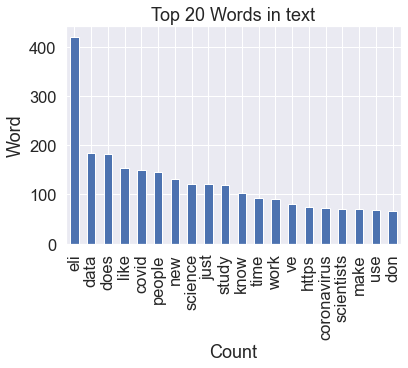

In [314]:
#sum_words = dtm.sum(axis=0) 
wc_top20= dtm.sum(axis=0).sort_values(ascending=False)[:20]
wc_top20.plot(kind='bar')
plt.title('Top 20 Words in text')
plt.xlabel('Count')
plt.ylabel('Word')

In [315]:
vect.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [306]:
# Random Forest
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(X_train_tfidf,y_train)
print(RF_trained_model)

y_train_pred= RF_model.predict(X_train_tfidf)
y_test_pred= RF_model.predict(X_test_tfidf)


print("Random Forest train Accuracy:",metrics.accuracy_score(y_train, y_train_pred))
print("Random Forest test Accuracy:",metrics.accuracy_score(y_test, y_test_pred))

RandomForestClassifier()
Random Forest train Accuracy: 0.8124284077892325
Random Forest test Accuracy: 0.7124856815578465


In [318]:
list_pickle_path = 'vect.pkl'
# Create an variable to pickle and open it in write mode
pickle.dump(vect, open(list_pickle_path, 'wb'))

In [323]:
list_pickle_path = 'RFC_model.pkl'
# Create an variable to pickle and open it in write mode
pickle.dump(RF_model, open(list_pickle_path, 'wb'))

In [320]:
list_pickle_path = 'encoder.pkl'
# Create an variable to pickle and open it in write mode
pickle.dump(encoder, open(list_pickle_path, 'wb'))

In [329]:
encoder = pickle.load(open('encoder.pkl', 'rb'))
vect = pickle.load(open('vect.pkl', 'rb'))
model = pickle.load(open('RFC_model.pkl', 'rb'))

In [336]:
pred = model.predict(vect.transform(["i want to learn Data science"]))
pred_encoded = encoder.inverse_transform(pred)
print ("predicted class:", pred_encoded)

predicted class: ['datascience']
